In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm

mnist_data = MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

mnist_test_data = MNIST(
    root = 'data',
    train = False,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

In [3]:
from torch import nn

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )
    def forward(self, x):
        return self.net(x)

In [4]:
from torch.utils.data import DataLoader, Dataset, RandomSampler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)

nepochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loader = DataLoader(mnist_data, batch_size=64, sampler=RandomSampler(mnist_data))
loss_fn = torch.nn.CrossEntropyLoss()

In [5]:
import torch.nn.functional as F
from tqdm import tqdm

running_loss = 0
for epoch in range(nepochs):
    for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch:{epoch+1}/{nepochs}"):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()
        
        running_loss = loss.item()
    print(f"{running_loss=:.3f}")



Epoch:1/10: 100%|██████████| 938/938 [00:21<00:00, 43.52it/s]


running_loss=0.302


Epoch:2/10: 100%|██████████| 938/938 [00:16<00:00, 56.48it/s]


running_loss=0.439


Epoch:3/10: 100%|██████████| 938/938 [00:16<00:00, 55.39it/s]


running_loss=0.378


Epoch:4/10: 100%|██████████| 938/938 [00:17<00:00, 54.05it/s]


running_loss=0.068


Epoch:5/10: 100%|██████████| 938/938 [00:16<00:00, 57.40it/s]


running_loss=0.073


Epoch:6/10: 100%|██████████| 938/938 [00:16<00:00, 58.40it/s]


running_loss=0.053


Epoch:7/10: 100%|██████████| 938/938 [00:18<00:00, 51.77it/s]


running_loss=0.014


Epoch:8/10: 100%|██████████| 938/938 [00:15<00:00, 60.78it/s]


running_loss=0.017


Epoch:9/10: 100%|██████████| 938/938 [00:16<00:00, 58.03it/s]


running_loss=0.017


Epoch:10/10: 100%|██████████| 938/938 [00:16<00:00, 58.05it/s]

running_loss=0.005


In [6]:
test_loader = DataLoader(mnist_test_data, shuffle=True)
correct = 0
with torch.no_grad():
    for input, target in test_loader:
        input = input.to(device)
        target = target.to(device)
        prediction = model(input)
        
        if target.item() == prediction.argmax().item():
            correct += 1

print(f"correct={correct/len(test_loader)}")

correct=0.9831


In [7]:
from typing import List

class ActivationExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: List[int]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._activations = {layer: torch.empty(0) for layer in layers}
        
        for layer in layers:
            self.model.net[layer].register_forward_hook(self._get_activation(layer))
        
    def _get_activation(self, layer: int):
        def hook(_, __, output):
            self._activations[layer] = output.detach()
                
        return hook
    
    def forward(self, x: torch.Tensor):
        self.model(x)
        return self._activations

In [8]:
monitored_layers = [6, 7, 9, 11]
layer_dims = {6: 400, 7: 120, 9: 84, 11: 10}

activations = {layer: torch.empty(0) for layer in monitored_layers}
activation = ActivationExtractor(model, layers=monitored_layers)
test_loader = DataLoader(mnist_test_data, shuffle=True)
targets = []
with torch.no_grad():
    for input, target in tqdm(test_loader, total=len(test_loader)):
        input = input.to(device)
        targets.append(target.item())
        act = activation(input)
        for layer in monitored_layers:
            activations[layer] = torch.cat((activations[layer], act[layer]), dim=0)
        


100%|██████████| 10000/10000 [00:42<00:00, 236.65it/s]


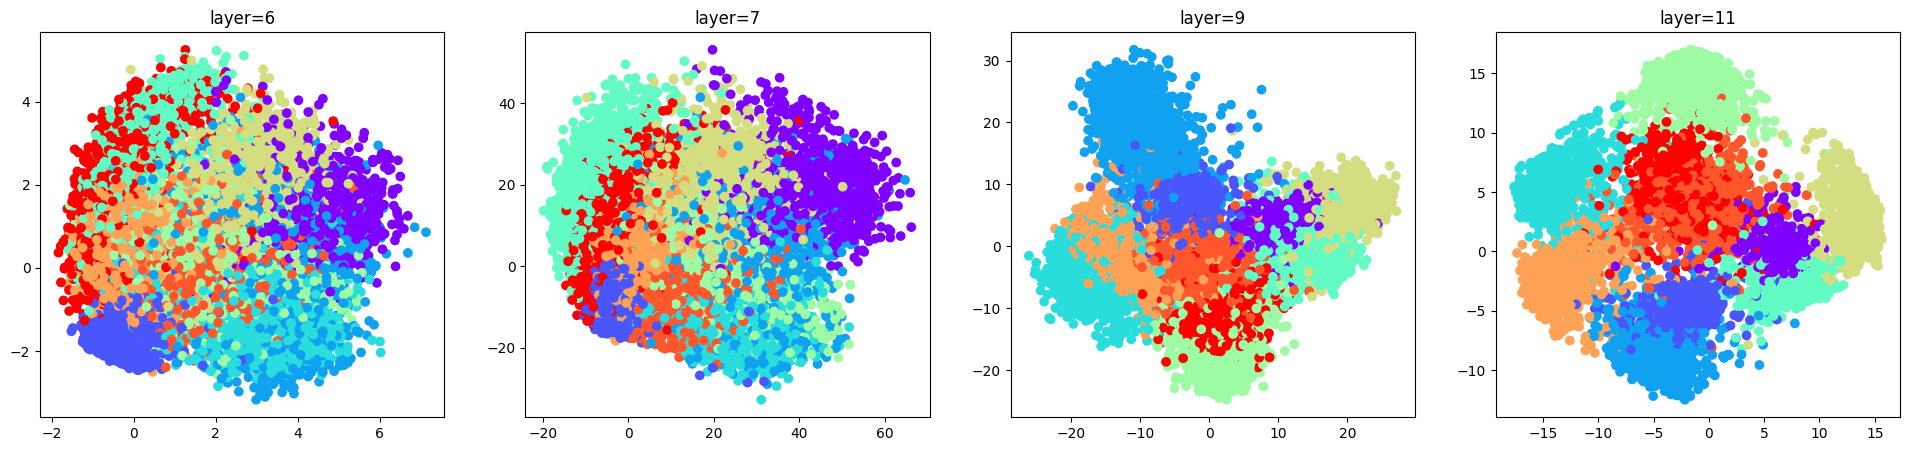

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

fig, ax = plt.subplots(1, 4, figsize=(24, 5))
for idx, layer in enumerate(monitored_layers):
    pca.fit(activations[layer].numpy())
    components = torch.tensor(pca.components_)
    projection = torch.mm(activations[layer], components.T)

    ax[idx].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')
    ax[idx].set_title(f"{layer=}")

In [10]:
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler
import torch.nn.functional as F
from transformations import Transform

class TripletLoader:
    def __init__(self, dataset: Dataset, transforms: Transform):
        self.dataset = dataset
        self.transforms = transforms
        
    def __call__(self, nsamples: int):
        self.nsamples = nsamples
        self._initialize_loader()
        return self
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current < self.nsamples:
            self.current += 1
            samples, targets = self._triplet()
            transformed_samples = [self.transforms(samples[i], label=targets[i].item()) for i in range(3)]
            return transformed_samples
        raise StopIteration
    
    def _initialize_loader(self):
        self.loader = DataLoader(self.dataset, sampler=RandomSampler(self.dataset), batch_size=100)
        self.current = 0
        
    def _triplet(self):
        anchor_idx, positive_idx, negative_idx = 0, float('inf'), float('inf')
        s, t = next(iter(self.loader))
        while torch.tensor(positive_idx).isinf() or torch.tensor(negative_idx).isinf():
            try:
                positive_idx = (t == t[0]).nonzero().flatten()[1].item()
                negative_idx = (t != t[0]).nonzero().flatten()[1].item()
            except IndexError:
                s, t = next(iter(self.loader))
        indices = [anchor_idx, positive_idx, negative_idx]
        return s[indices], t[indices]
        

In [36]:
from torch.linalg import multi_dot

def siamese_grad(weights: torch.Tensor, embeddings: torch.Tensor, alpha: float = 0.5):
    grad = torch.zeros_like(weights)
    emb_anc = torch.mm(embeddings[0], weights)
    emb_pos = torch.mm(embeddings[1], weights)
    emb_neg = torch.mm(embeddings[2], weights)
    
    d_pos = torch.norm(emb_pos - emb_anc)
    d_neg = torch.norm(emb_neg - emb_anc)
    d_pos_neg = emb_pos - emb_neg
    if d_pos - d_neg + alpha > 0:
        grad = multi_dot((weights, emb_anc.T, d_pos_neg)) + multi_dot((weights, d_pos_neg.T, emb_anc)) - torch.mm(weights, torch.mm(emb_pos.T, emb_pos) - torch.mm(emb_neg.T, emb_neg))
    return grad, d_pos - d_neg + alpha

In [23]:
from torch.linalg import multi_dot
from torch.nn.functional import normalize

def siamese_grad_cosine(weights: torch.Tensor, embeddings: torch.Tensor, alpha: float = 1.0):
    grad = torch.zeros_like(weights)
    emb_anc = normalize(torch.mm(embeddings[0], weights), p=2, dim=1)
    emb_pos = normalize(torch.mm(embeddings[1], weights), p=2, dim=1)
    emb_neg = normalize(torch.mm(embeddings[2], weights), p=2, dim=1)
    
    d_pos = 1 - torch.mm(emb_anc, emb_pos.T)
    d_neg = 1 - torch.mm(emb_anc, emb_neg.T)
    
    if d_pos - d_neg + alpha > 0:
        #print(d_pos, d_neg)
        grad = multi_dot((weights, emb_anc.T, emb_pos - emb_neg))
    return grad, d_pos - d_neg + alpha

In [14]:
import transformations
from transformations import Scale, Identity, ToVector

triplet_loader = TripletLoader(mnist_data, transforms=Identity())

In [39]:
layer = 7
layer_dim = 120

nepochs = 10
nbatches = 300
batch_size = 64
lr = 0.01

weights = torch.randn(layer_dim, layer_dim)

for epoch in range(nepochs):
    batch_loss = 0
    for batches in tqdm(range(nbatches), desc=f"Epoch:{epoch+1}/{nepochs}"):
        grad = torch.zeros(120, 120)
        loss = 0
        for triplet in triplet_loader(batch_size):
            anc = triplet[0].unsqueeze(0).to(device)
            pos = triplet[1].unsqueeze(0).to(device)
            neg = triplet[2].unsqueeze(0).to(device)
            
            emb_anc = activation(anc)[layer]
            emb_pos = activation(pos)[layer]
            emb_neg = activation(neg)[layer]
            
            g, l = siamese_grad(weights, [emb_anc, emb_pos, emb_neg], alpha=100)
            grad += g
            loss += l
        weights += lr*grad/batch_size
        batch_loss += loss/batch_size
    print(f"loss={batch_loss/nbatches}")

Epoch:1/10: 100%|██████████| 300/300 [04:43<00:00,  1.06it/s]


loss=nan


Epoch:2/10: 100%|██████████| 300/300 [05:17<00:00,  1.06s/it]


loss=nan


Epoch:3/10: 100%|██████████| 300/300 [05:11<00:00,  1.04s/it]


loss=nan


Epoch:4/10: 100%|██████████| 300/300 [04:58<00:00,  1.01it/s]


loss=nan


Epoch:5/10: 100%|██████████| 300/300 [05:04<00:00,  1.01s/it]


loss=nan


Epoch:6/10: 100%|██████████| 300/300 [04:38<00:00,  1.08it/s]


loss=nan


Epoch:7/10: 100%|██████████| 300/300 [04:44<00:00,  1.05it/s]


loss=nan


Epoch:8/10: 100%|██████████| 300/300 [04:43<00:00,  1.06it/s]


loss=nan


Epoch:9/10: 100%|██████████| 300/300 [04:50<00:00,  1.03it/s]


loss=nan


Epoch:10/10: 100%|██████████| 300/300 [04:54<00:00,  1.02it/s]

loss=nan


/Users/rraj/Library/Python/3.8/lib/python/site-packages/sklearn/decomposition/_pca.py:642: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


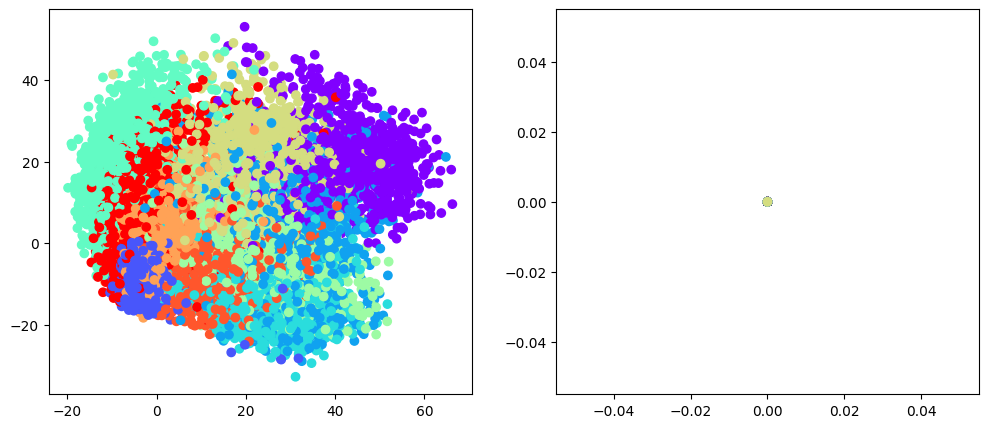

In [40]:
layer = 7
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

pca.fit(activations[layer].numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(activations[layer], components.T)
ax[0].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

transformed_activations = normalize(torch.mm(activations[layer], weights), p=2, dim=1)
pca.fit(transformed_activations.numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(transformed_activations, components.T)
ax[1].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

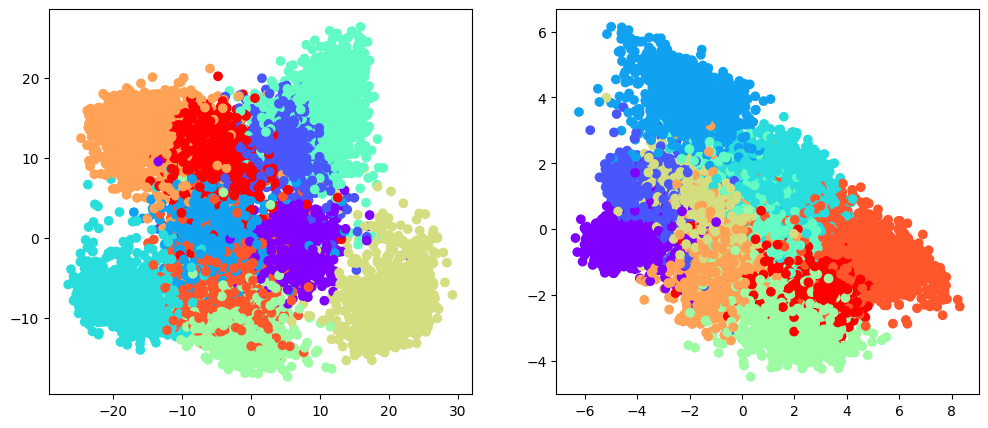

In [18]:
layer = 9
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

pca.fit(activations[layer].numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(activations[layer], components.T)
ax[0].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

transformed_activations = torch.mm(activations[layer], weights)
pca.fit(transformed_activations.numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(activations[layer], components.T)
ax[1].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

In [25]:
from layers import DiscriminationModule
from initialization import DatasetInitializer
from loading import SequentialLoader

transform = transformations.Compose([Scale(), ToVector()])
triplet_loader_dc = TripletLoader(mnist_data, transforms=transform)
loader = SequentialLoader(mnist_data, transforms=transform)

dcnet = DiscriminationModule(500, DatasetInitializer(mnist_data, transforms=transform), beta=0.98)

In [26]:
nbatches = 100
batch_size = 200
for _ in tqdm(range(nbatches)):
    for x in loader(batch_size):
        dcnet(x)
    dcnet.organize()

100%|██████████| 100/100 [1:00:27<00:00, 36.27s/it]


In [28]:
nepochs = 1
nbatches = 100
batch_size = 64
lr = 0.01

weights = torch.randn(500, 500)

for epoch in range(nepochs):
    for batches in tqdm(range(nbatches), desc=f"Epoch:{epoch+1}/{nepochs}"):
        grad = torch.zeros(500, 500)
        for triplet in triplet_loader_dc(batch_size):
            anc = triplet[0]
            pos = triplet[1]
            neg = triplet[2]
            
            emb_anc = dcnet(anc)
            emb_pos = dcnet(pos)
            emb_neg = dcnet(neg)
            
            grad += siamese_grad(weights, [emb_anc, emb_pos, emb_neg])
        weights += lr*grad/batch_size

Epoch:1/1: 100%|██████████| 100/100 [58:19<00:00, 34.99s/it]


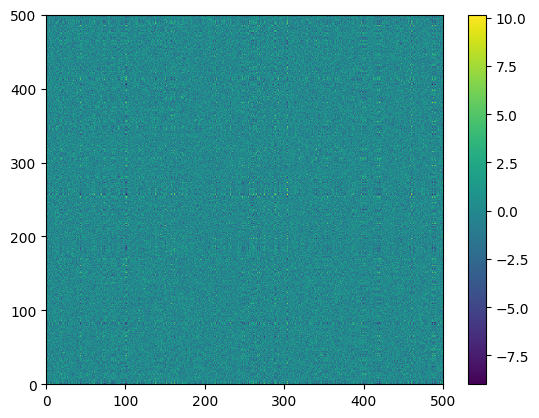

In [29]:
plt.pcolormesh(weights)
plt.colorbar()

In [30]:
test_loader = DataLoader(mnist_test_data, shuffle=True)
targets = []
activations = torch.empty(0)
transformed_activations = torch.empty(0)
for idx, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        input, target = data
        targets.append(target.item())
        input = transform(input)
        output = dcnet(input)
        tranformed_output = torch.mm(output, weights)
        activations = torch.cat((activations, output), dim=0)
        transformed_activations = torch.cat((transformed_activations, tranformed_output), dim=0)
        
        if idx >= 2000:
                break        

 20%|██        | 2000/10000 [06:16<25:06,  5.31it/s]  


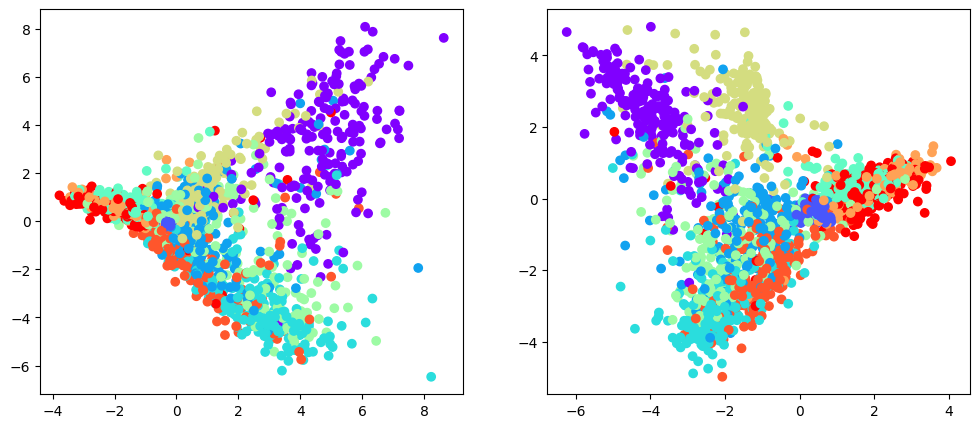

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

pca.fit(activations.numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(activations, components.T)
ax[0].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

pca.fit(transformed_activations.numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(activations, components.T)
ax[1].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

In [18]:
64*938

60032